# DFTK showcases and examples

This notebook shows a selection of our documented examples at https://docs.dftk.org

## Tutorial

(see also https://docs.dftk.org/dev/guide/tutorial)

We look again at the classic example of
computing the LDA ground state of the silicon crystal. First we run the SCF:

In [1]:
using DFTK
using Plots

# 1. Define lattice and atomic positions
a = 10.26  # Silicon lattice constant in Bohr
lattice = a / 2 * [[0 1 1.];
                   [1 0 1.];
                   [1 1 0.]]
Si = ElementPsp(:Si, psp=load_psp("hgh/lda/Si-q4"))
atoms = [Si => [ones(3)/8, -ones(3)/8]]

# 2. Select model and basis
model = model_LDA(lattice, atoms)
kgrid = [4, 4, 4]  # k-point grid
Ecut = 7           # kinetic energy cutoff in Hartree (small one for fast calculations)
basis = PlaneWaveBasis(model, Ecut; kgrid=kgrid)

# 3. Run the SCF procedure to obtain the ground state
scfres = self_consistent_field(basis, tol=1e-8);

n     Energy            Eₙ-Eₙ₋₁     ρout-ρin   Diag
---   ---------------   ---------   --------   ----
  1   -7.905277917258         NaN   1.95e-01    4.2 
  2   -7.909885993408   -4.61e-03   2.98e-02    1.0 
  3   -7.910108505727   -2.23e-04   3.05e-03    3.0 
  4   -7.910109391917   -8.86e-07   4.73e-04    2.5 
  5   -7.910109412406   -2.05e-08   3.94e-05    2.0 
  6   -7.910109414107   -1.70e-09   4.52e-06    3.1 


Now one can get various quantities from the result of the SCF.
For instance, the different components of the energy:

In [2]:
scfres.energies

Energy breakdown:
    Kinetic             3.0807741 
    AtomicLocal         -2.1784526
    AtomicNonlocal      1.7341071 
    Ewald               -8.4004648
    PspCorrection       -0.2948928
    Hartree             0.5413917 
    Xc                  -2.3925721

    total               -7.910109414107


Eigenvalues:

In [3]:
hcat(scfres.eigenvalues...)

7×10 Matrix{Float64}:
 -0.170033  -0.13162    -0.0881027  …  -0.0560212  -0.114744   -0.0697774
  0.201708   0.0912092   0.0125263      0.0114069   0.0423174   0.0179169
  0.249664   0.175086    0.176465       0.133225    0.220465    0.112584
  0.249664   0.231788    0.202704       0.16134     0.220466    0.190778
  0.351459   0.360507    0.340562       0.292133    0.321216    0.32774
  0.370379   0.396308    0.389908   …   0.332169    0.388572    0.46072
  0.370379   0.402092    0.41287        0.566099    0.388572    0.463163

`eigenvalues` is an array (indexed by kpoints) of arrays (indexed by
eigenvalue number). The "splatting" operation `...` calls `hcat`
with all the inner arrays as arguments, which collects them into a
matrix.

The resulting matrix is 7 (number of computed eigenvalues) by 8
(number of kpoints). There are 7 eigenvalues per kpoint because
there are 4 occupied states in the system (4 valence electrons per
silicon atom, two atoms per unit cell, and paired spins), and the
eigensolver gives itself some breathing room by computing some extra
states (see `n_ep_extra` argument to `self_consistent_field`).

We can check the occupations:

In [4]:
hcat(scfres.occupation...)

7×10 Matrix{Float64}:
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

And density:

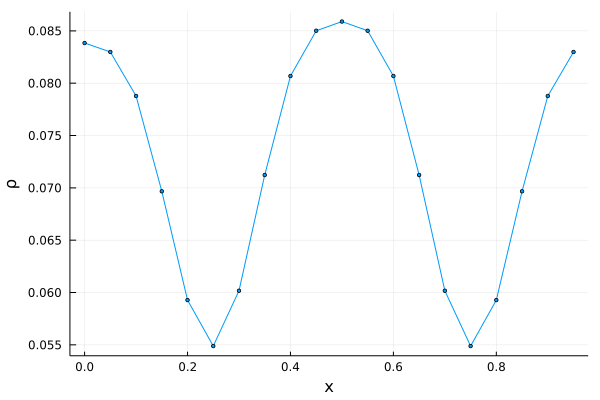

In [8]:
rvecs = collect(r_vectors(basis))[:, 1, 1]  # slice along the x axis
x = [r[1] for r in rvecs]                   # only keep the x coordinate
plot(x, total_density(scfres.ρ)[:, 1, 1], label="", xlabel="x", ylabel="ρ", marker=2)

As we saw before, we can also perform various postprocessing steps:
for instance compute a band structure

Computing bands along kpath:
       Γ -> X -> W -> K -> Γ -> L -> U -> W -> L -> K  and  U -> X


Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:01


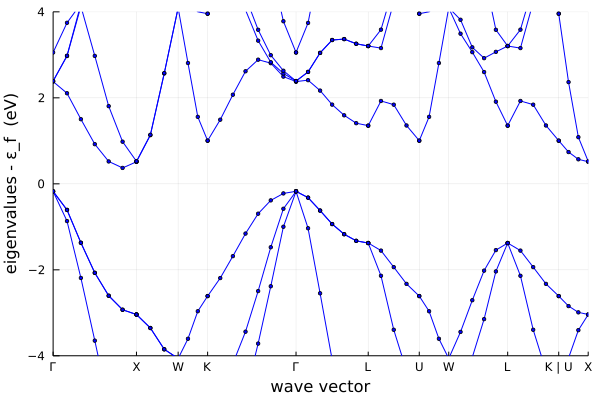

In [11]:
plot_bandstructure(scfres, kline_density=5)

or forces

In [7]:
compute_forces_cart(scfres)[1]  # Select silicon forces

┌ Warning: Forces for shifted k-Grids not tested
└ @ DFTK /home/mfh/.julia/packages/DFTK/ojXaV/src/terms/terms.jl:72


2-element Vector{StaticArrays.SVector{3, Float64}}:
 [0.0004499412850086663, 0.0004499412835963938, 0.00044993969782068703]
 [-0.0004499412835961455, -0.00044994128500900374, -0.0004499396978204936]

The `[1]` extracts the forces for the first kind of atoms,
i.e. `Si` (silicon) in the setup of the `atoms` list of step 1 above.
As expected, they are almost zero in this highly symmetric configuration.

# Building complex structures with ASE
(see also https://docs.dftk.org/dev/examples/ase/)



Parameters of the calculation. Since the surface we tackle is far from easy to converge,
we chose a very small `Ecut` and small values for `n_Si` and `n_vacuum`.
More interesting settings are `Ecut = 15` and `n_Si = n_vacuum = 20`.

In [12]:
miller = (1, 1, 0)   # Surface Miller indices
n_Si = 4             # Number of GaAs layers
n_vacuum = 4         # Number of vacuum layers
Ecut = 5             # Hartree
kgrid = (4, 4, 1);   # Monkhorst-Pack mesh

Use ASE to build the structure:

In [1]:
using PyCall

ase_build = pyimport("ase.build")
si = ase_build.bulk("Si")
surface = ase_build.surface(si, miller, n_Si, 0, periodic=true);

LoadError: UndefVarError: miller not defined

Get the amount of vacuum in Ångström we need to add

In [14]:
d_vacuum = maximum(maximum, surface.cell) / n_Si * n_vacuum
surface = ase_build.surface(si, miller, n_Si, d_vacuum, periodic=true)

# Write an image of the surface to a file to be able to look at it:
pyimport("ase.io").write("img/surface.png", surface * (3, 3, 1), rotation="-90x, 30y, -75z")

This will look like:
<img src="img/surface.png" width=500 height=500 />

Use the `load_atoms` and `load_lattice` functions
to convert to DFTK datastructures.
These two functions not only support importing ASE atoms into DFTK,
but a few more third-party datastructures as well.
Typically the imported `atoms` use a bare Coulomb potential,
such that appropriate pseudopotentials need to be attached in a post-step:

In [15]:
using DFTK

atoms = load_atoms(surface)
atoms = [ElementPsp(el.symbol, psp=load_psp(el.symbol, functional="pbe")) => position
         for (el, position) in atoms]
lattice = load_lattice(surface);

We model this surface with (quite large a) temperature of 0.01 Hartree
to ease convergence. Try lowering the SCF convergence tolerance (`tol`
or the `temperature` to see the full challenge of this system.

In [17]:
model = model_PBE(lattice, atoms, temperature=0.001, smearing=DFTK.Smearing.Gaussian())
basis = PlaneWaveBasis(model, Ecut; kgrid=kgrid)

scfres = self_consistent_field(basis, tol=1e-6, mixing=DielectricMixing(εr=12));

n     Free energy       Eₙ-Eₙ₋₁     ρout-ρin   Diag
---   ---------------   ---------   --------   ----
  1   -31.07271743650         NaN   3.62e-01    6.5 
  2   -31.10082120401   -2.81e-02   1.02e-01    1.0 
  3   -31.10515390254   -4.33e-03   1.46e-02    6.5 
  4   -31.10632604139   -1.17e-03   8.31e-03    9.0 
  5   -31.10635980905   -3.38e-05   6.45e-03    5.2 
  6   -31.10665453489   -2.95e-04   1.22e-03    3.2 
  7   -31.10666547468   -1.09e-05   8.87e-04    3.0 
  8   -31.10667500488   -9.53e-06   3.41e-04    4.5 
  9   -31.10667682607   -1.82e-06   2.02e-04    4.2 
 10   -31.10667741401   -5.88e-07   1.52e-04    4.5 


# Arbitrary floating-point types

(see also https://docs.dftk.org/dev/examples/arbitrary_floattype/)



In [18]:
using DFTK

# Setup silicon lattice
a = 10.263141334305942  # lattice constant in Bohr
lattice = a / 2 .* [[0 1 1.]; [1 0 1.]; [1 1 0.]]
Si = ElementPsp(:Si, psp=load_psp(:Si, functional="lda"))
atoms = [Si => [ones(3)/8, -ones(3)/8]]

# Cast to Float32, setup model and basis
model = model_DFT(Array{Float32}(lattice), atoms, [:lda_x, :lda_c_vwn])
Ecut = 7
basis = PlaneWaveBasis(model, Ecut, kgrid=[4, 4, 4])

# Run the SCF
scfres = self_consistent_field(basis, tol=1e-4);

n     Energy            Eₙ-Eₙ₋₁     ρout-ρin   Diag
---   ---------------   ---------   --------   ----
  1   -7.907588958740         NaN   1.95e-01    4.2 
  2   -7.912189483643   -4.60e-03   2.99e-02    1.0 
  3   -7.912419319153   -2.30e-04   3.03e-03    3.1 
  4   -7.912419795990   -4.77e-07   4.61e-04    2.4 


Computing bands along kpath:
       Γ -> X -> W -> K -> Γ -> L -> U -> W -> L -> K  and  U -> X


Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:04


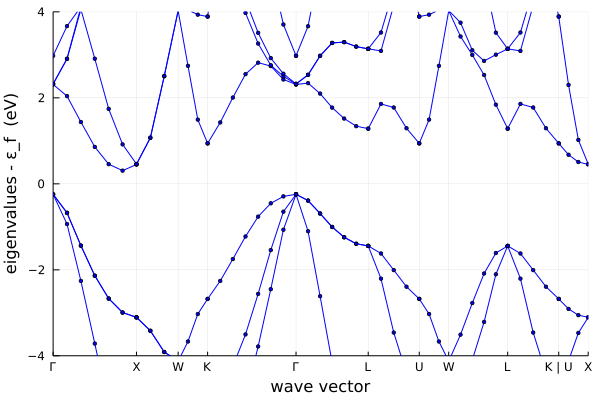

In [19]:
plot_bandstructure(scfres, kline_density=5)

In [20]:
compute_forces_cart(scfres)[1]

┌ Warning: Forces for shifted k-Grids not tested
└ @ DFTK /home/mfh/.julia/packages/DFTK/ojXaV/src/terms/terms.jl:72


2-element Vector{StaticArrays.SVector{3, Float32}}:
 [0.00047312593, 0.00047400262, 0.00047426485]
 [-0.0004741486, -0.0004730075, -0.0004742632]

# Custom models and solvers
(see https://docs.dftk.org/dev/examples/custom_solvers/)

In [21]:
using DFTK

# Setup silicon lattice
a = 10.263141334305942  # lattice constant in Bohr
lattice = a / 2 .* [[0 1 1.]; [1 0 1.]; [1 1 0.]]
Si = ElementPsp(:Si, psp=load_psp("hgh/lda/Si-q4"))
atoms = [Si => [ones(3)/8, -ones(3)/8]]

# We build an LDA model, where the XC term is artificially scaled
# For precision we use Float32
terms_two_electron = [Hartree(),
                      Xc([:lda_x, :lda_c_vwn], scaling_factor=10)]

model = model_atomic(Array{Float32}(lattice), atoms,
                     extra_terms=terms_two_electron)
kgrid = [3, 3, 3]
Ecut = 5
basis = PlaneWaveBasis(model, Ecut; kgrid=kgrid);

We define our custom SCF solver: Simply a damped fixed-point solver:

In [26]:
function my_fp_solver(f, x0, max_iter; tol)
    T = eltype(x0)
    mixing_factor = T(.7)
    x = x0
    fx = f(x)
    for n = 1:max_iter
        inc = fx - x
        if norm(inc) < tol
            break
        end
        x = x + mixing_factor * inc
        fx = f(x)
    end
    (fixpoint=x, converged=norm(fx-x) < tol)
end;

Our eigenvalue solver just forms the dense matrix and diagonalizes it explicitly (this only works for very small systems)

In [27]:
function my_eig_solver(A, X0; maxiter, tol, kwargs...)
    n = size(X0, 2)
    A = Array(A)
    E = eigen(A)
    λ = E.values[1:n]
    X = E.vectors[:, 1:n]
    (λ=λ, X=X, residual_norms=[], iterations=0, converged=true, n_matvec=0)
end;

Finally we also define our custom mixing scheme. It will be a mixture of simple mixing (for the first 2 steps) and than default to Kerker mixing.

In [28]:
struct MyMixing
    n_simple  # Number of iterations for simple mixing
end
MyMixing() = MyMixing(2)

function DFTK.mix(mixing::MyMixing, basis, δF; n_iter, kwargs...)
    if n_iter <= mixing.n_simple
        return δF  # Simple mixing -> Do not modify update at all
    else
        # Use the default KerkerMixing from DFTK
        DFTK.mix(KerkerMixing(), basis, δF; kwargs...)
    end
end

That's it! Now we just run the SCF with these solvers

In [30]:
scfres = self_consistent_field(basis;
                               tol=1e-8,
                               solver=my_fp_solver,
                               eigensolver=my_eig_solver,
                               mixing=MyMixing());

n     Energy            Eₙ-Eₙ₋₁     ρout-ρin   Diag
---   ---------------   ---------   --------   ----
  1   -32.00089645385         NaN   3.89e-01    0.0 
  2   -33.53807830810   -1.54e+00   4.12e-01    0.0 
  3   -34.94078063964   -1.40e+00   4.42e-01    0.0 
  4   -35.80633544921   -8.66e-01   4.08e-01    0.0 
  5   -36.24921417236   -4.43e-01   3.22e-01    0.0 
  6   -36.44743728637   -1.98e-01   2.31e-01    0.0 
  7   -36.53372955322   -8.63e-02   1.58e-01    0.0 
  8   -36.57154083252   -3.78e-02   1.06e-01    0.0 
  9   -36.58834075927   -1.68e-02   6.95e-02    0.0 
 10   -36.59589004516   -7.55e-03   4.56e-02    0.0 
 11   -36.59933090210   -3.44e-03   2.98e-02    0.0 
 12   -36.60090255737   -1.57e-03   1.96e-02    0.0 
 13   -36.60163497924   -7.32e-04   1.29e-02    0.0 
 14   -36.60196685791   -3.32e-04   8.54e-03    0.0 
 15   -36.60213470459   -1.68e-04   5.67e-03    0.0 
 16   -36.60221099853   -7.63e-05   3.79e-03    0.0 
 17   -36.60224151611   -3.05e-05   2.55e-03    